# oxford_flowers102 with resnet and adam

## 1) Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import json
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## 2) Loading and summarizing data and creating data pipelines

In [2]:
data, dataset_info = tfds.load('oxford_flowers102', split='train+test+validation', as_supervised = True, with_info = True)
datalen = [i for i,_ in enumerate(data)][-1] + 1
datalen

train_split = int(0.6*datalen)
test_val_split = int(0.2*datalen)
test_val_split = int(0.2*datalen)

training_set = data.take(train_split)
test_set = data.skip(train_split)
validation_set = test_set.skip(test_val_split)
test_set = test_set.take(test_val_split)

dataset=training_set,validation_set,test_set

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

### From the above datset_info we can see that the data is split into train, test and validation batches and each image has features like filename, label and image itself(255 pixels) which can be harnessed whenever needed

In [4]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples + dataset_info.splits['validation'].num_examples

num_training_examples = train_split
num_validation_examples = test_val_split
num_test_examples = num_validation_examples

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in our dataset'.format(num_classes))

There are 4,913 images in the training set
There are 1,637 images in the validation set
There are 1,637 images in the test set
There are 102 classes in our dataset


In [5]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [6]:
def resize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224], preserve_aspect_ratio=False)
    image /= 255
    return image, label

batch_size = 32
image_size = 224

training_batches = training_set.cache().shuffle(num_training_examples//4).map(resize).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().map(resize).batch(batch_size).prefetch(1)
testing_batches = test_set.cache().map(resize).batch(batch_size).prefetch(1)

## 3) Creating models, plots and test data evaluation

In [7]:
pretrained_model = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"

In [8]:
lr = 0.001

decay_steps = 100000
decay_rate = 0.95

exp_lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps, decay_rate)

In [9]:
def plotter(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
 
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
def summary_plot(pretrained_model,losses,accuracies):
    plt.figure(figsize=(8, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(all_optimizers, losses)
    plt.xlabel("Gradient Descent Variants")
    plt.ylabel("Loss Values")
    plt.title('Testing Loss Summary')

    plt.subplot(1, 2, 2)
    plt.bar(all_optimizers, accuracies)
    plt.xlabel("Gradient Descent Variants")
    plt.ylabel("Accuracy Values")
    plt.title('Testing Accuracy Summary')
    
    plt.show()
    

Epoch 1/25
154/154 [==============================] - 341s 2s/step - loss: 1.8971 - accuracy: 0.6161 - val_loss: 0.7067 - val_accuracy: 0.8755
Epoch 2/25
154/154 [==============================] - 337s 2s/step - loss: 0.3972 - accuracy: 0.9369 - val_loss: 0.4667 - val_accuracy: 0.9018
Epoch 3/25
154/154 [==============================] - 330s 2s/step - loss: 0.2008 - accuracy: 0.9782 - val_loss: 0.3728 - val_accuracy: 0.9213
Epoch 4/25
154/154 [==============================] - 329s 2s/step - loss: 0.1200 - accuracy: 0.9931 - val_loss: 0.3180 - val_accuracy: 0.9292
Epoch 5/25
154/154 [==============================] - 330s 2s/step - loss: 0.0783 - accuracy: 0.9974 - val_loss: 0.2972 - val_accuracy: 0.9317
Epoch 6/25
154/154 [==============================] - 329s 2s/step - loss: 0.0556 - accuracy: 0.9980 - val_loss: 0.2781 - val_accuracy: 0.9323
Epoch 7/25
154/154 [==============================] - 330s 2s/step - loss: 0.0419 - accuracy: 0.9996 - val_loss: 0.2577 - val_accuracy: 0.9414

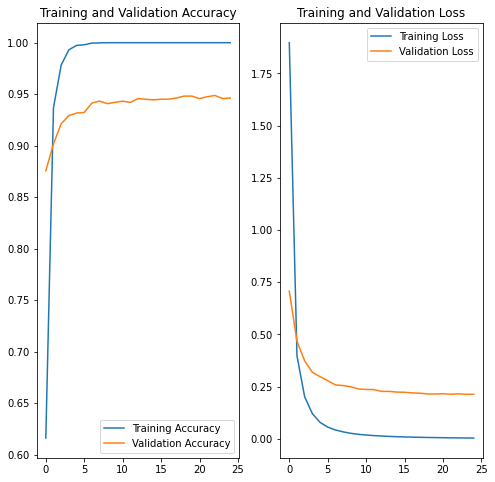

52/52 [==============================] - 80s 2s/step - loss: 0.1914 - accuracy: 0.9475

Loss on the TEST Set: 0.191

Accuracy on the TEST Set: 94.746%


In [11]:
EPOCHS = 25

feature_extractor = hub.KerasLayer(pretrained_model, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation ='softmax')])
    
           
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=exp_lr_scheduler),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
        

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data=validation_batches) 
        

        
plotter(history)
        
loss, accuracy = model.evaluate(testing_batches)
        
       
print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('\nAccuracy on the TEST Set: {:.3%}'.format(accuracy))
        
    